In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
# rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
P = covariance.make_correlation_matrix(
    rho, rho0, covariance.correlation_sqd_exp)

R = np.eye(obs_size)

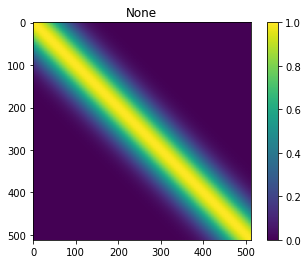

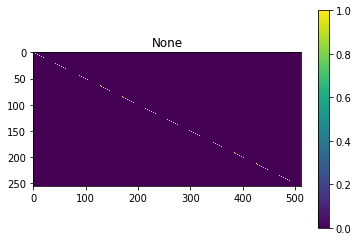

In [7]:
imshow(P, vmin=0)
imshow(H)

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, P=P,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


In [9]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

# Smaller ens_size

In [10]:
ens_ens_size = 3
ens_size = 20
mu = np.zeros(dimension)
ensemble_array = np.ones(
    [dimension, ens_size, ens_ens_size,
    ]) * np.nan
for t_num in range(ens_ens_size):
    ensemble_array[:, :, t_num] = (
        assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt']))

In [11]:
P_sample_array = np.zeros([dimension, dimension, ens_ens_size])
for ens_ens_num in range(ens_ens_size):
    P_sample_array[:, :, ens_ens_num] = np.cov(ensemble_array[:, :, ens_ens_num])

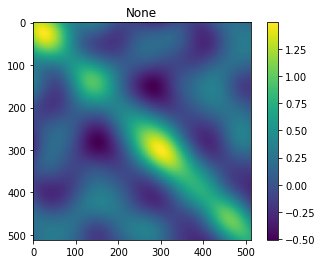

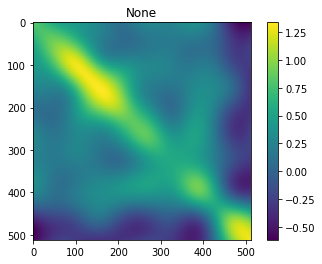

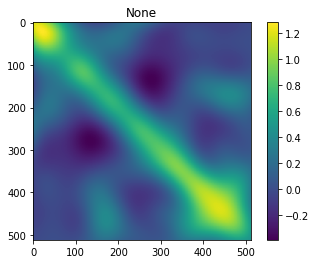

In [12]:
for ens_ens_num in range(ens_ens_size):
    imshow(P_sample_array[:, :, ens_ens_num])

In [13]:
sig_array = np.concatenate(
    [[3], np.repeat([2], 11)])
rho_array = np.linspace(0.01, 0.3, 40)
total_sig = sig_array.sum()
sig_bin_num = sig_array.size

s_array = np.ones([total_sig, rho_array.size, ens_ens_size]) * np.nan
U_array = np.ones([obs_size, total_sig, rho_array.size, ens_ens_size]) * np.nan
V_array = np.ones([dimension, total_sig, rho_array.size, ens_ens_size]) * np.nan

sig_num = sig_array[0]

#proj_array = np.ones([dimension, dimension, ens_ens_size]) * np.nan
eye_array = np.repeat(np.eye(dimension)[:, :, None], ens_ens_size, axis=-1)
proj_array = eye_array.copy()


V_average_angle_2_truth= np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
V_average_angle = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan

error_n2 = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
exp_error_n2 = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))


opt_rho_array = np.ones(sig_bin_num) * np.nan
opt_rho_index_array = opt_rho_array.copy()
opt_s_array = np.ones([total_sig, ens_ens_size]) * np.nan
opt_U_array = np.ones([obs_size, total_sig, ens_ens_size]) * np.nan
opt_V_array = np.ones([dimension, total_sig, ens_ens_size]) * np.nan

In [14]:
last_sig = 0
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print(sig_slice)
    last_sig = last_sig + sig_num
    true_V = VT[sig_slice].T
    reduced_true = (U[:, sig_slice]
                    @ S[sig_slice, sig_slice]
                    @ VT[sig_slice])
    for rho_count, rho_loc in enumerate(rho_array):
        [loc] = covariance.generate_circulant(
            dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
            return_Corr=True, return_eig=False)
        loc /= loc.max()
        reduced_array = np.ones([obs_size,
                                 dimension,
                                 ens_ens_size]) * np.nan
        for ens_count in range(ens_ens_size):
            P_loc = (P_sample_array[:, :, ens_count] * loc
                     @ proj_array[:, :, ens_count])
            this_trans_mats = assimilate.transformation_matrices(
                H, P=P_loc,
                R=R, return_Ts=True)

            aU = this_trans_mats['U']
            aS = this_trans_mats['S']
            aVT = this_trans_mats['VT']

            U_array[:, sig_slice, rho_count, ens_count] = aU[:, :sig_num]
            s_array[sig_slice, rho_count, ens_count] = aS.diagonal()[:sig_num]
            V_array[:, sig_slice, rho_count, ens_count] = aVT[:sig_num, :].T
            
            reduced_array[:, :, ens_count] = (
                aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
            
        angle_2_truth = np.ones(ens_ens_size) * np.nan
        ens_error_n2 = np.ones(ens_ens_size) * np.nan
        
        comb_count = 0
        angles = np.ones(comb_num) * np.nan
        errors = np.ones(comb_num) * np.nan
        for ens_count in range(ens_ens_size):
            aV = V_array[:, sig_slice, rho_count, ens_count]
            
            angle_2_truth[ens_count] = angle(aV, true_V)
            ens_error_n2[ens_count] = sp.linalg.norm(
                reduced_array[:, :, ens_count] - reduced_true,
                ord=2)
            for other_ens_count in range(ens_count + 1, ens_ens_size):
                oV = V_array[:, sig_slice, rho_count, other_ens_count]
                this_angle = angle(aV, oV)
                angles[comb_count] = this_angle
                this_error = sp.linalg.norm(
                    reduced_array[:, :, ens_count]
                    - reduced_array[:, :, other_ens_count],
                    ord=2)
                errors[comb_count] = this_error
                comb_count += 1
        V_average_angle[sig_count, rho_count] = angles.mean()
        V_average_angle_2_truth[sig_count, rho_count] = angle_2_truth.mean()
        error_n2[sig_count, rho_count] = ens_error_n2.mean()
        exp_error_n2[sig_count, rho_count] = errors.mean()
        
    opt_rho_index =  V_average_angle[sig_count].argmin()
    opt_rho_index_array[sig_count] = opt_rho_index
    opt_rho_array[sig_count] = rho_array[opt_rho_index]
    opt_U_array[:, sig_slice] = U_array[:, sig_slice, opt_rho_index, :]
    opt_s_array[sig_slice] = s_array[sig_slice, opt_rho_index, :]
    V_opt = V_array[:, sig_slice, opt_rho_index, :]
    opt_V_array[:, sig_slice] = V_opt
    
    this_proj = eye_array - np.einsum('ij...,kj...->ik...', V_opt, V_opt)
    proj_array = np.einsum('ij...,jk...->ik...', proj_array, this_proj)

slice(0, 3, None)
slice(3, 5, None)
slice(5, 7, None)
slice(7, 9, None)
slice(9, 11, None)
slice(11, 13, None)
slice(13, 15, None)
slice(15, 17, None)
slice(17, 19, None)
slice(19, 21, None)
slice(21, 23, None)
slice(23, 25, None)


Ens size: 20 

Ens of ens size: 3 

Current singular values: slice(0, 3, None) 

Minimize norm2 error: 0.129 

Minimize average angle among ensembles: 0.3 

Minimize average angle from truth: 0.08436 

Current singular values: slice(3, 5, None) 

Minimize norm2 error: 0.3 

Minimize average angle among ensembles: 0.1215 

Minimize average angle from truth: 0.3 

Current singular values: slice(5, 7, None) 

Minimize norm2 error: 0.1513 

Minimize average angle among ensembles: 0.1067 

Minimize average angle from truth: 0.1215 

Current singular values: slice(7, 9, None) 

Minimize norm2 error: 0.2256 

Minimize average angle among ensembles: 0.129 

Minimize average angle from truth: 0.1364 

Current singular values: slice(9, 11, None) 

Minimize norm2 error: 0.1662 

Minimize average angle among ensembles: 0.06949 

Minimize average angle from truth: 0.1364 

Current singular values: slice(11, 13, None) 

Minimize norm2 error: 0.1215 

Minimize average angle among ensembles: 0.05462 


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Current singular values: slice(23, 25, None) 

Minimize norm2 error: 0.1067 

Minimize average angle among ensembles: 0.02487 

Minimize average angle from truth: 0.02487 



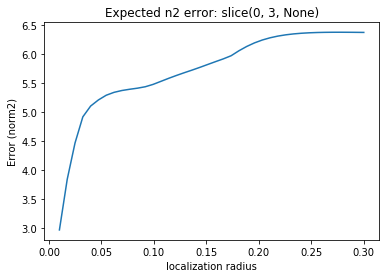

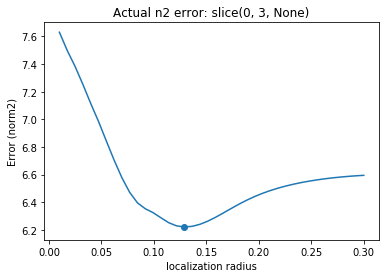

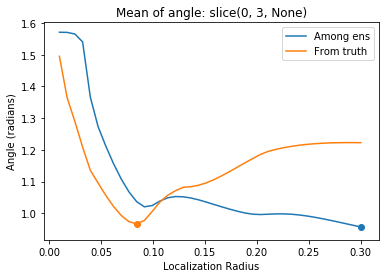

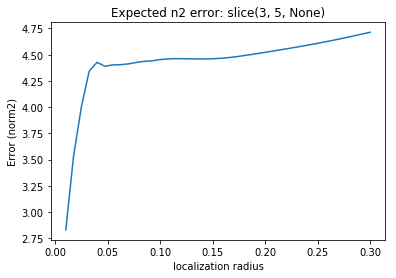

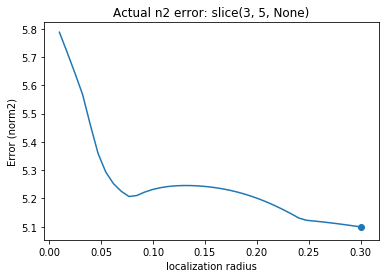

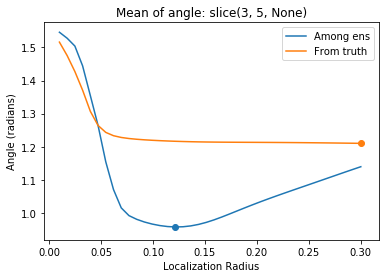

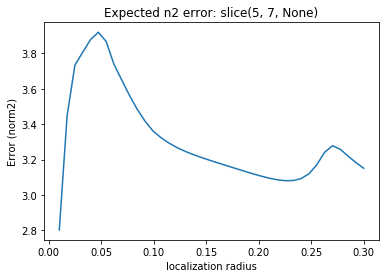

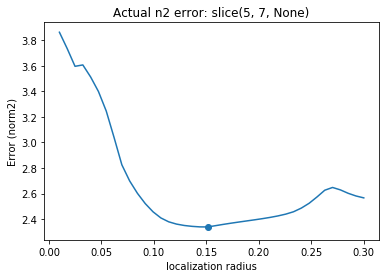

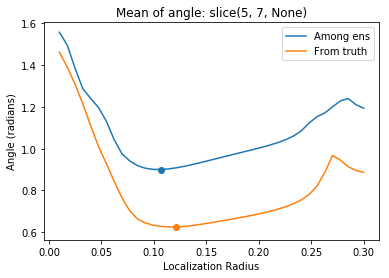

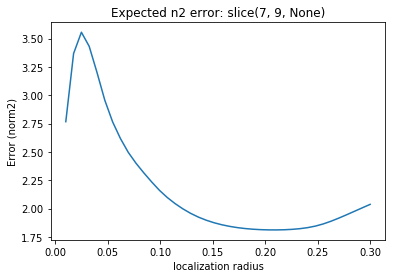

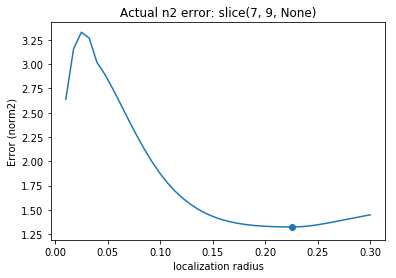

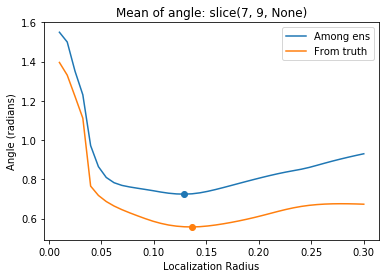

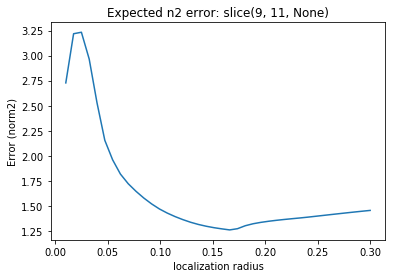

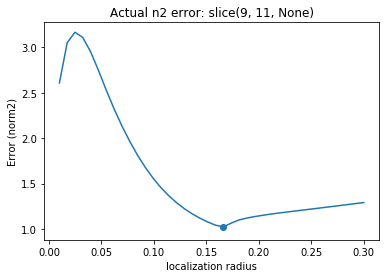

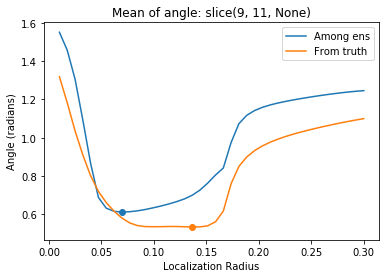

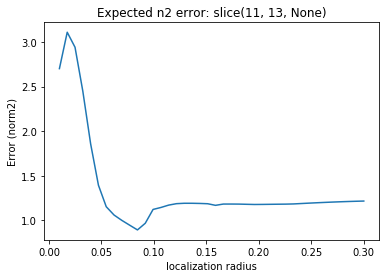

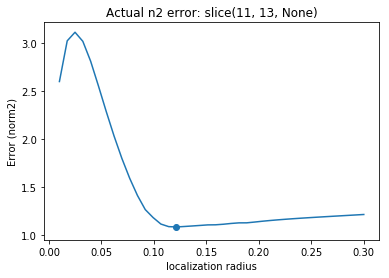

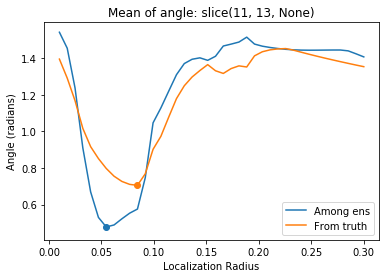

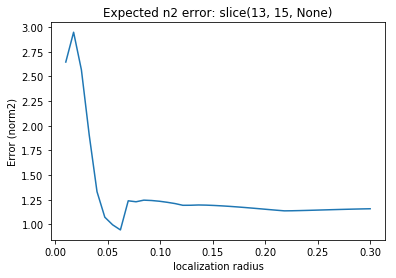

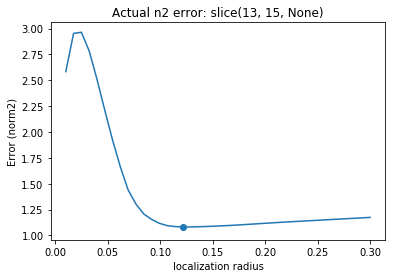

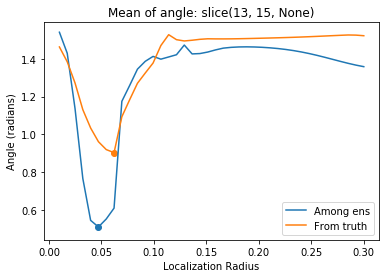

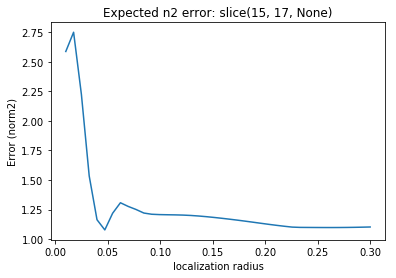

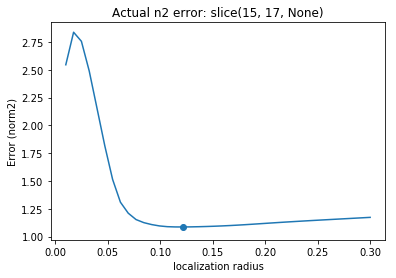

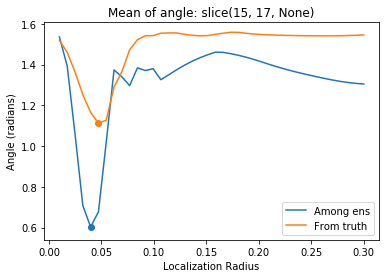

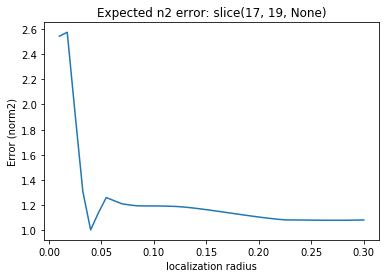

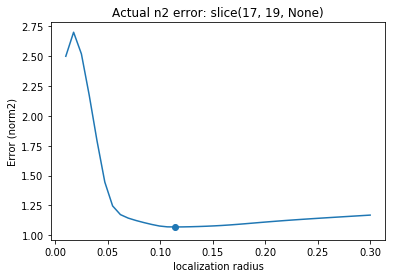

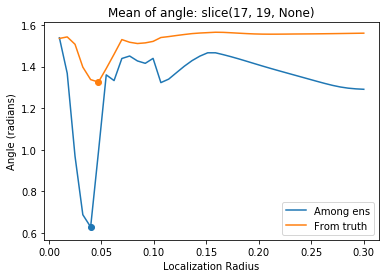

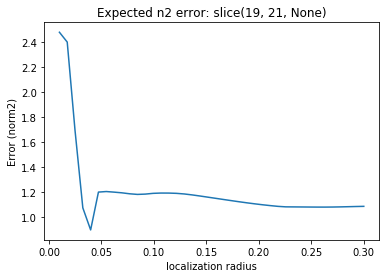

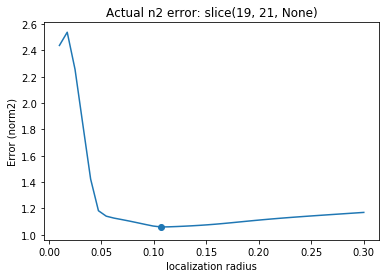

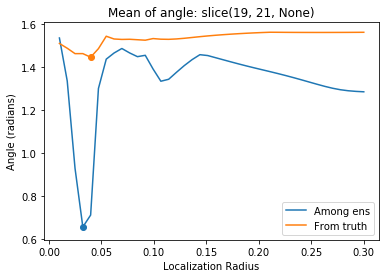

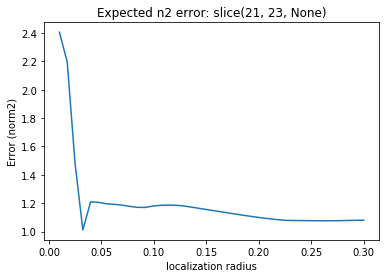

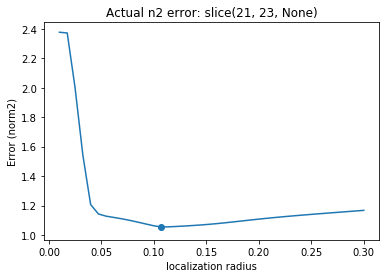

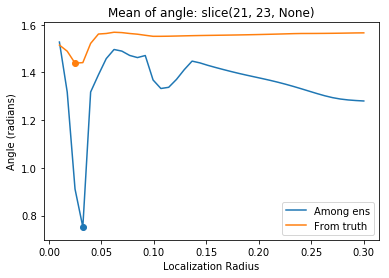

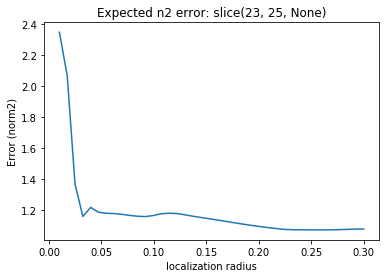

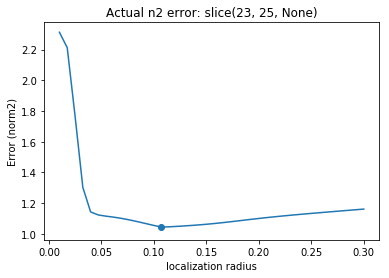

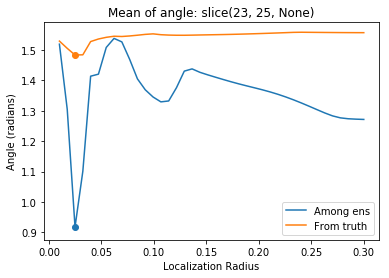

In [15]:
last_sig = 0
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    last_sig = last_sig + sig_num
    print(f'Current singular values: {sig_slice}', '\n')

    e2_arg = error_n2[sig_count].argmin()
    this_rho = rho_array[e2_arg]
    print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

    ea_arg = V_average_angle[sig_count].argmin()
    this_rho = rho_array[ea_arg]
    print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

    aa_arg = V_average_angle_2_truth[sig_count].argmin()
    this_rho = rho_array[aa_arg]
    print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')
    
    plt.figure()
    plt.plot(rho_array, exp_error_n2[sig_count])
    plt.title(f'Expected n2 error: {sig_slice}')
    plt.ylabel('Error (norm2)')
    plt.xlabel('localization radius')

    plt.figure()
    plt.plot(rho_array, error_n2[sig_count])
    plt.scatter(rho_array[e2_arg],
                error_n2[sig_count, e2_arg])
    plt.title(f'Actual n2 error: {sig_slice}')
    plt.ylabel('Error (norm2)')
    plt.xlabel('localization radius')


    plt.figure()
    plt.plot(rho_array, V_average_angle[sig_count])
    plt.plot(rho_array, V_average_angle_2_truth[sig_count])
    plt.scatter(rho_array[ea_arg],
                V_average_angle[sig_count, ea_arg])
    plt.scatter(rho_array[aa_arg],
                V_average_angle_2_truth[sig_count, aa_arg])
    plt.legend(['Among ens', 'From truth'])
    plt.xlabel('Localization Radius')
    plt.ylabel('Angle (radians)')
    plt.title(f'Mean of angle: {sig_slice}')

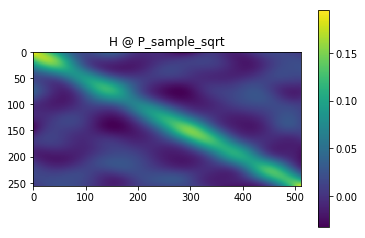

In [16]:
this_P_sqrt = covariance.matrix_sqrt(P_sample_array[:, :, 0]).real
imshow(H @ this_P_sqrt, 'H @ P_sample_sqrt')

# Using 'opt' singular values

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


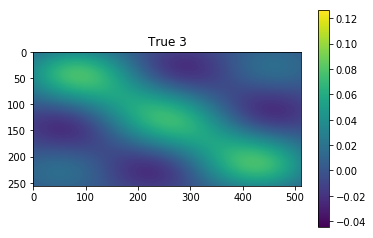

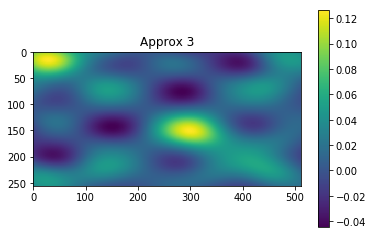

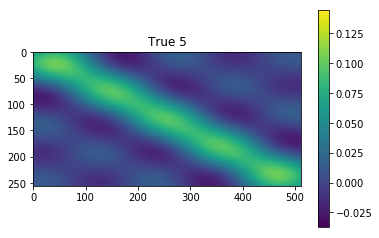

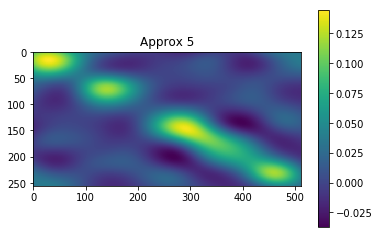

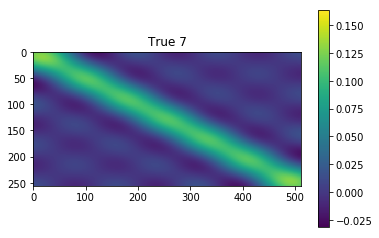

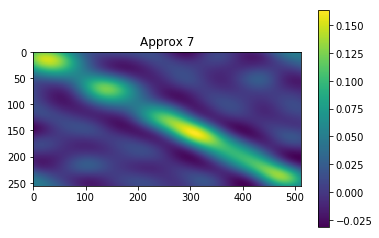

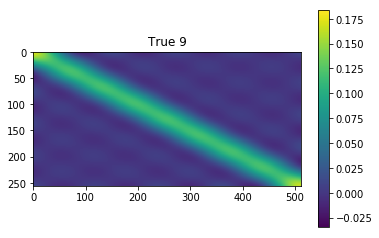

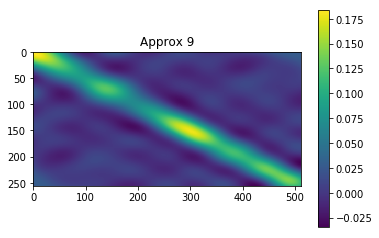

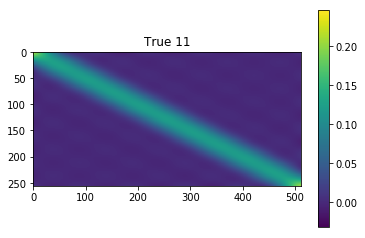

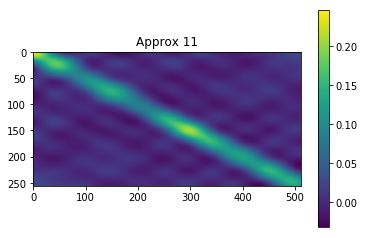

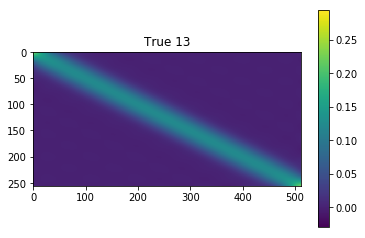

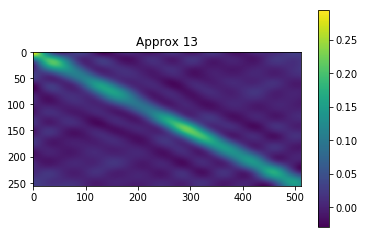

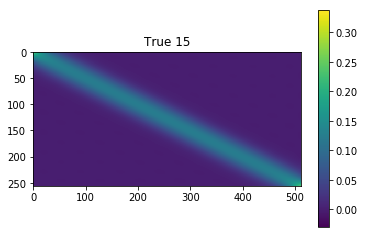

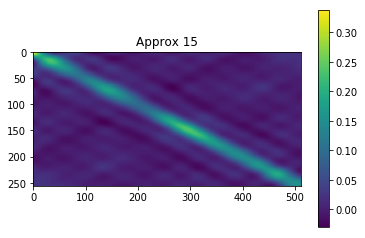

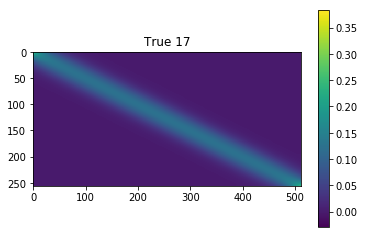

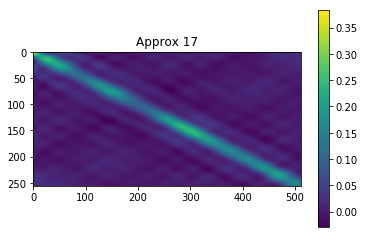

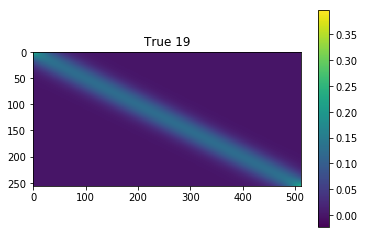

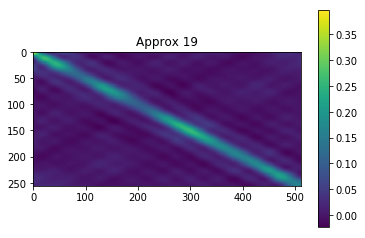

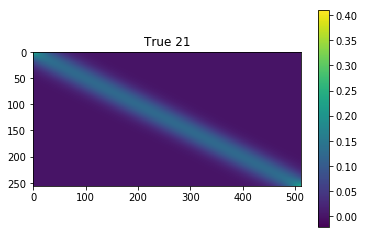

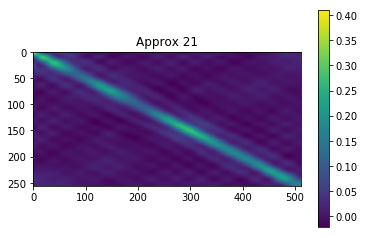

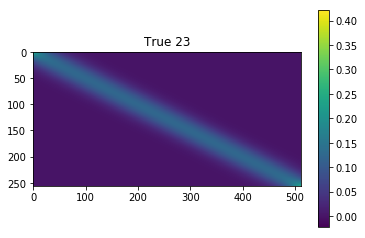

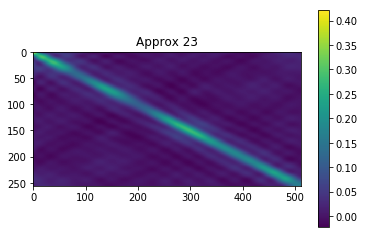

In [17]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig])
    for ens_count in range(1):
    #     this_P_sqrt = sp.linalg.sqrtm(P_sample_array[:, :, ens_count]).real
        this_recon = (
            opt_U_array[:, :this_sig, ens_count]
            @ np.diag(opt_s_array[:this_sig, ens_count])
            @ opt_V_array[:, :this_sig, ens_count].T)
        
#         this_recon = (
#             opt_U_array[:, :this_sig, ens_count]
#             @ S[:this_sig, :this_sig]
#             @ opt_V_array[:, :this_sig, ens_count].T)
        
        vmin = np.min([this_recon.min(), real_recon.min()])
        vmax = np.max([this_recon.max(), real_recon.max()])
        imshow(real_recon, vmin=vmin, vmax=vmax,
               title='True ' + str(this_sig))
        imshow(this_recon, vmin=vmin, vmax=vmax,
               title='Approx ' + str(this_sig))

# Using True singular values

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


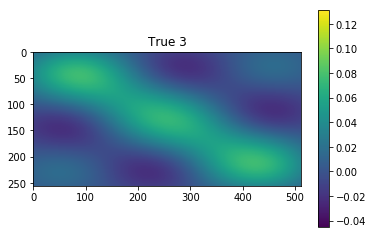

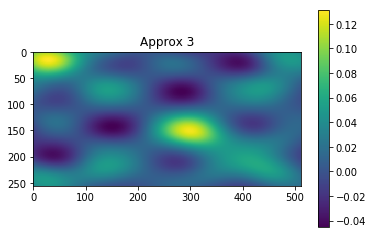

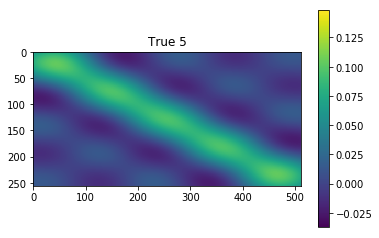

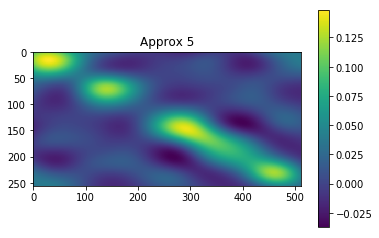

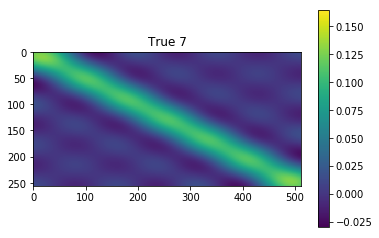

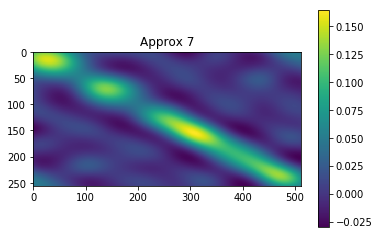

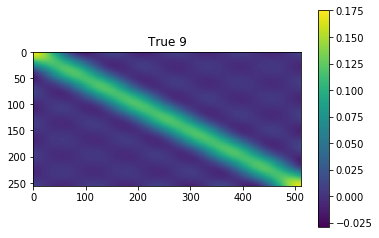

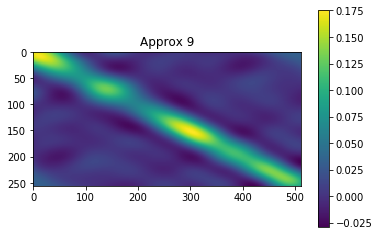

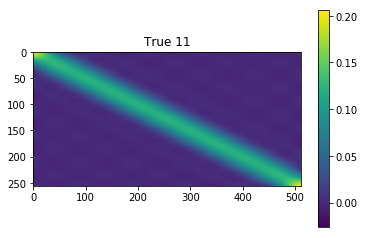

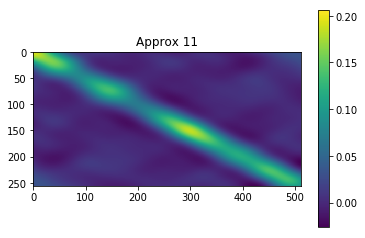

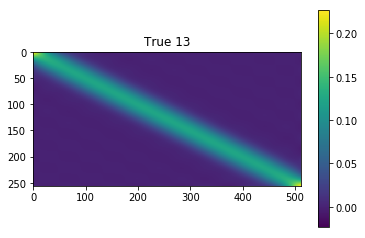

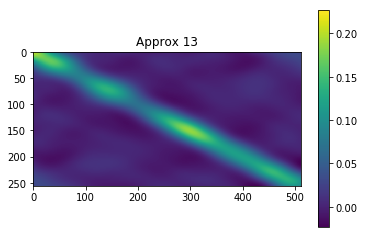

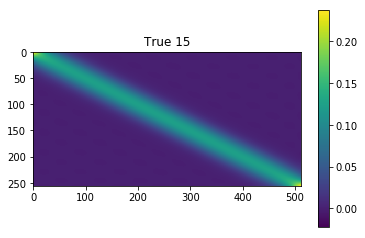

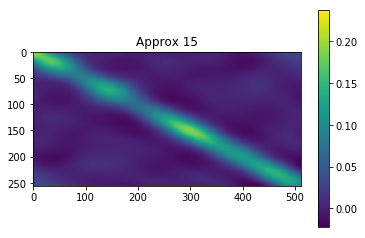

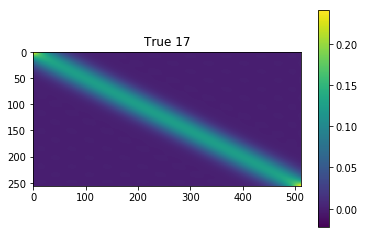

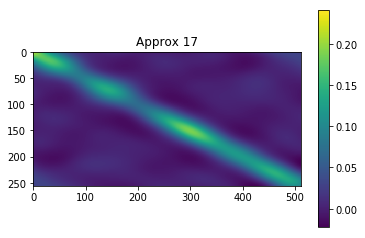

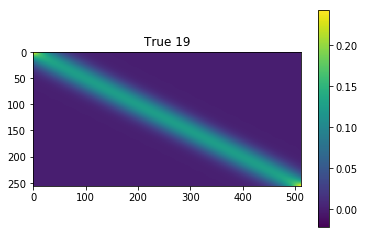

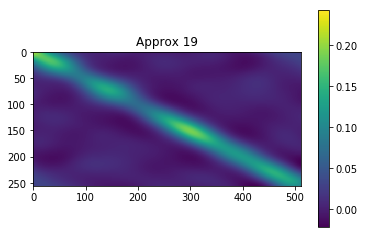

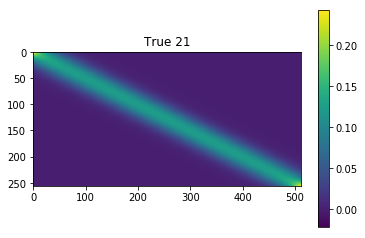

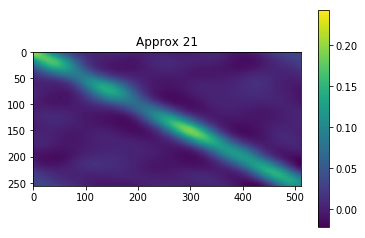

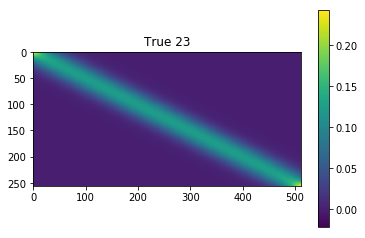

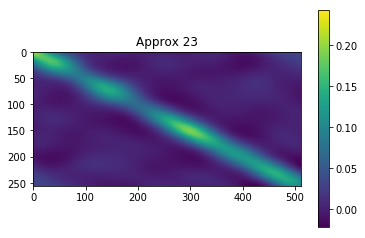

In [18]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig])
    for ens_count in range(1):
    #     this_P_sqrt = sp.linalg.sqrtm(P_sample_array[:, :, ens_count]).real
#         this_recon = (
#             opt_U_array[:, :this_sig, ens_count]
#             @ np.diag(opt_s_array[:this_sig, ens_count])
#             @ opt_V_array[:, :this_sig, ens_count].T)
        
        this_recon = (
            opt_U_array[:, :this_sig, ens_count]
            @ S[:this_sig, :this_sig]
            @ opt_V_array[:, :this_sig, ens_count].T)
        
        vmin = np.min([this_recon.min(), real_recon.min()])
        vmax = np.max([this_recon.max(), real_recon.max()])
        imshow(real_recon, vmin=vmin, vmax=vmax,
               title='True ' + str(this_sig))
        imshow(this_recon, vmin=vmin, vmax=vmax,
               title='Approx ' + str(this_sig))

In [19]:
sample_U_array = np.ones([obs_size, total_sig, ens_ens_size])
sample_s_array = np.ones([total_sig, ens_ens_size])
sample_V_array = np.ones([dimension, total_sig, ens_ens_size])
for ens_count in range(ens_ens_size):
    this_P = P_sample_array[:, :, ens_count]
    this_trans_mats = assimilate.transformation_matrices(
        H, P=this_P,
        R=R, return_Ts=True)

    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']

    sample_U_array[:, :, ens_count] = aU[:, :total_sig]
    sample_s_array[:, ens_count] = aS.diagonal()[:total_sig]
    sample_V_array[:, :, ens_count] = aVT[:total_sig, :].T

# Using Sample singular values

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


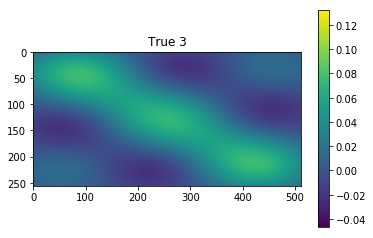

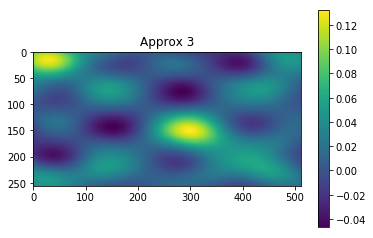

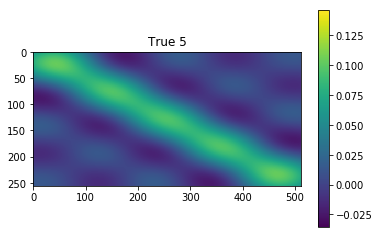

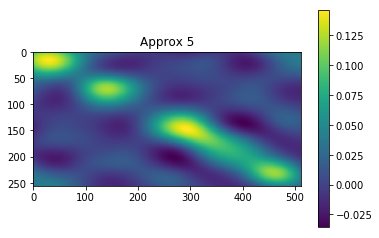

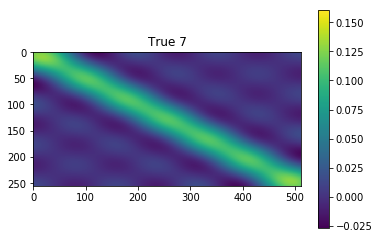

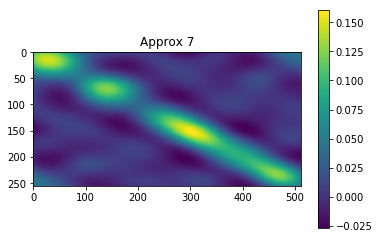

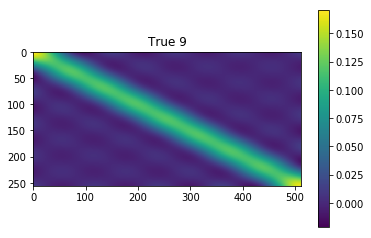

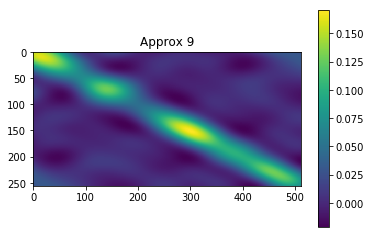

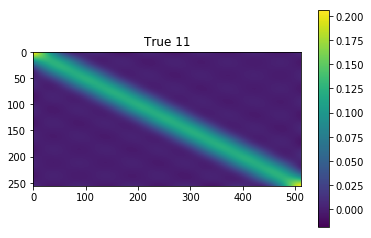

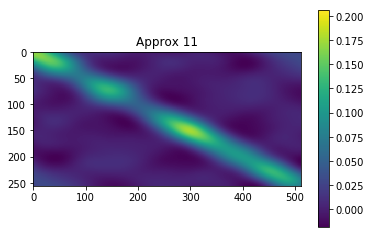

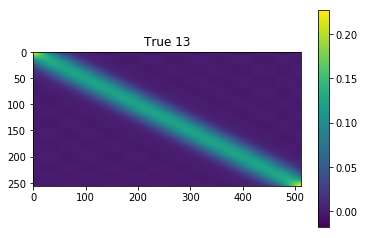

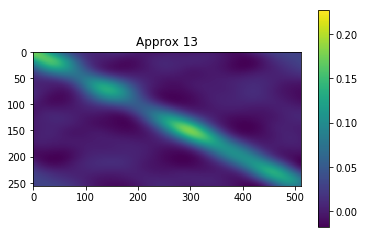

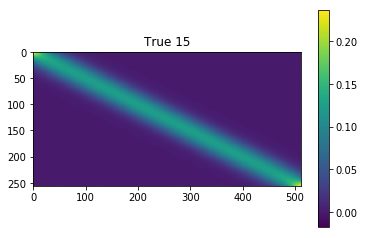

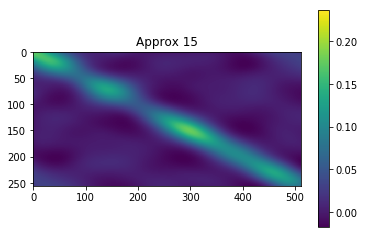

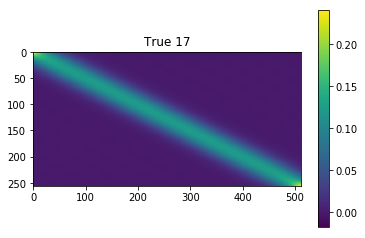

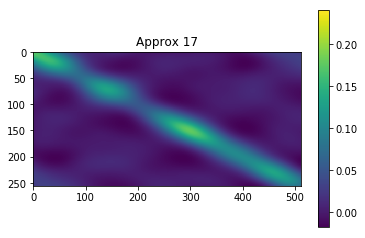

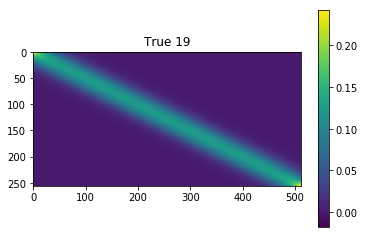

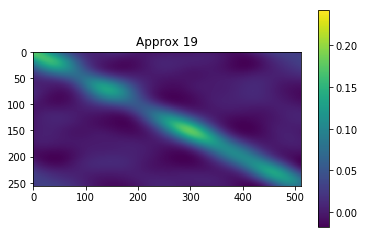

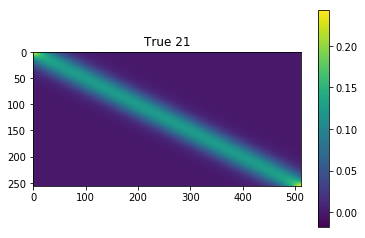

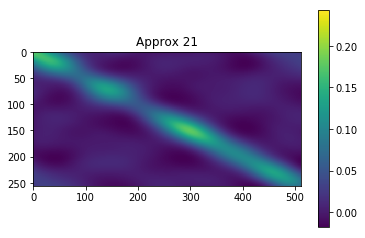

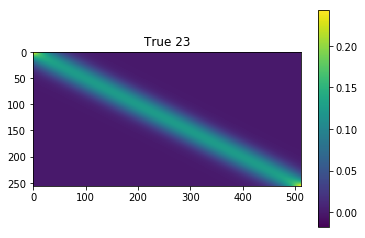

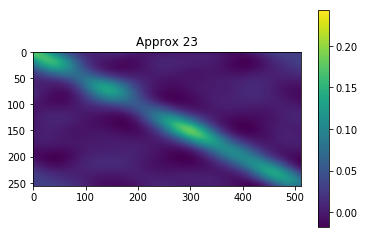

In [20]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig])
    for ens_count in range(1):
    #     this_P_sqrt = sp.linalg.sqrtm(P_sample_array[:, :, ens_count]).real
#         this_recon = (
#             opt_U_array[:, :this_sig, ens_count]
#             @ np.diag(opt_s_array[:this_sig, ens_count])
#             @ opt_V_array[:, :this_sig, ens_count].T)
        
        this_recon = (
            opt_U_array[:, :this_sig, ens_count]
            @ np.diag(sample_s_array[:this_sig, ens_count])
            @ opt_V_array[:, :this_sig, ens_count].T)
        
        vmin = np.min([this_recon.min(), real_recon.min()])
        vmax = np.max([this_recon.max(), real_recon.max()])
        imshow(real_recon, vmin=vmin, vmax=vmax,
               title='True ' + str(this_sig))
        imshow(this_recon, vmin=vmin, vmax=vmax,
               title='Approx ' + str(this_sig))

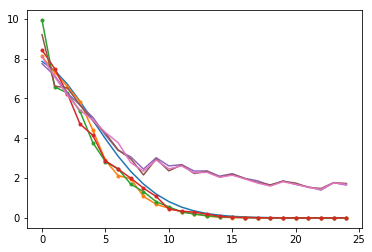

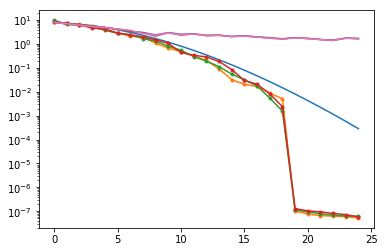

In [21]:
plt.figure()
plt.plot(S.diagonal()[:total_sig])
plt.plot(sample_s_array[:total_sig], marker='.')
plt.plot(opt_s_array[:total_sig])

plt.figure()
plt.semilogy(S.diagonal()[:total_sig])
plt.semilogy(sample_s_array[:total_sig], marker='.')
plt.semilogy(opt_s_array[:total_sig])

In [22]:
sample_angle = np.ones(sig_bin_num) * np.nan
last_sig = 0

for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    last_sig = last_sig + sig_num
    this_true_V = VT[sig_slice].T
    angles = np.ones(ens_ens_size) * np.nan
    for ens_count in range(ens_ens_size):
        this_V = sample_V_array[:, sig_slice, ens_count]
        angles[ens_count] = angle(this_V, this_true_V)
    sample_angle[sig_count] = angles.mean()

Text(0.5,0,'Singular value bin')

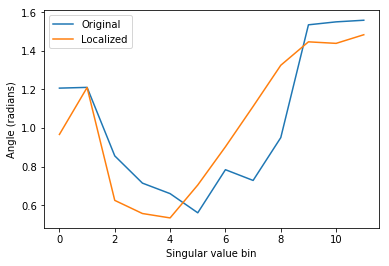

In [23]:
plt.figure()
plt.plot(sample_angle)
plt.plot(V_average_angle_2_truth.min(axis=-1))
plt.legend(['Original',
            'Localized'])
plt.ylabel('Angle (radians)')
plt.xlabel('Singular value bin')

Text(0,0.5,'Singular vector group')

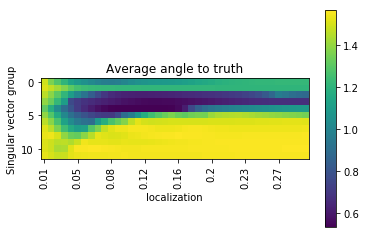

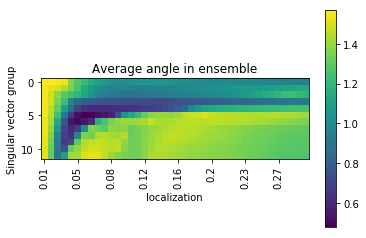

In [24]:
imshow(V_average_angle_2_truth,
       title='Average angle to truth')
plt.xticks(np.arange(rho_array.size)[::5],
           np.round(rho_array[::5], 2), rotation=90)
plt.xlabel('localization')
plt.ylabel('Singular vector group')

imshow(V_average_angle,
       title='Average angle in ensemble')
plt.xticks(np.arange(rho_array.size)[::5],
           np.round(rho_array[::5], 2), rotation=90)
plt.xlabel('localization')
plt.ylabel('Singular vector group')

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


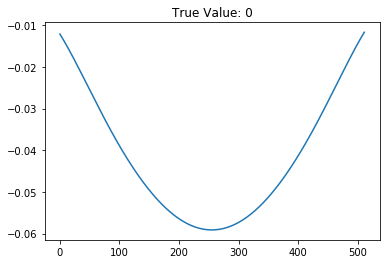

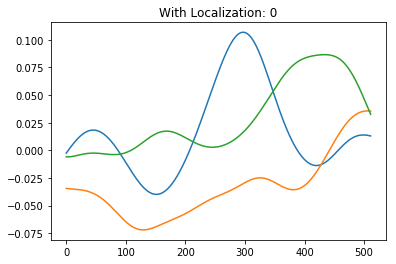

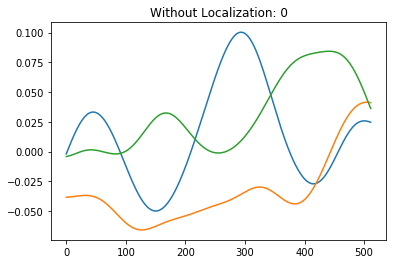

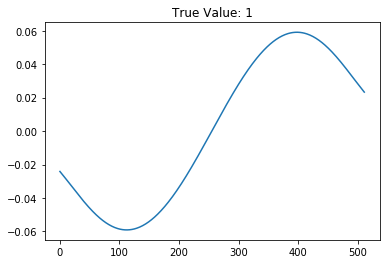

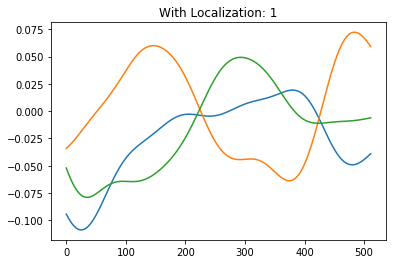

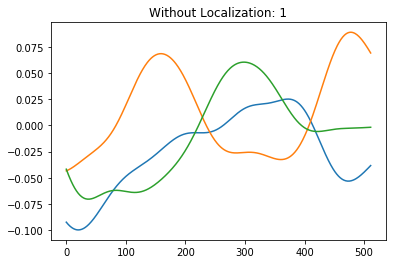

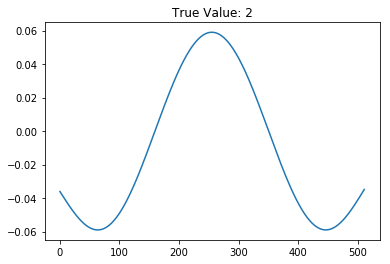

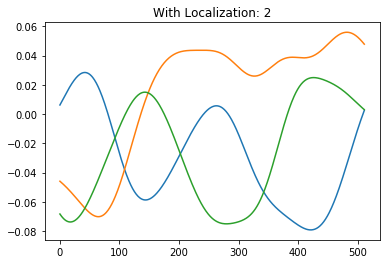

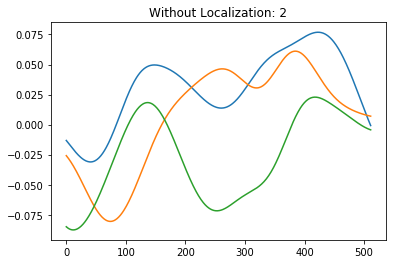

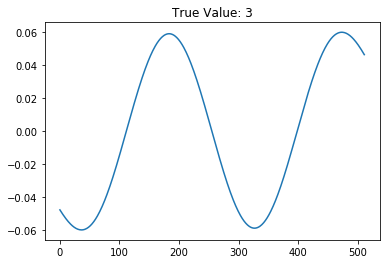

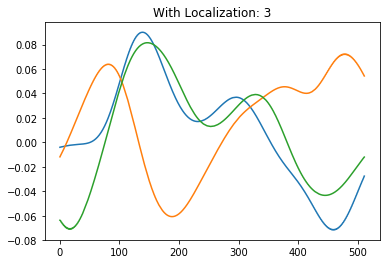

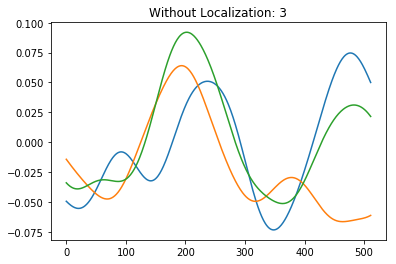

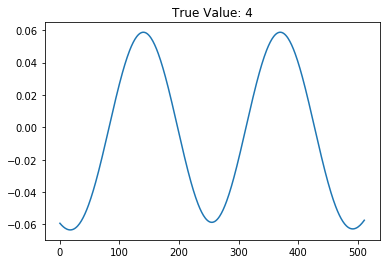

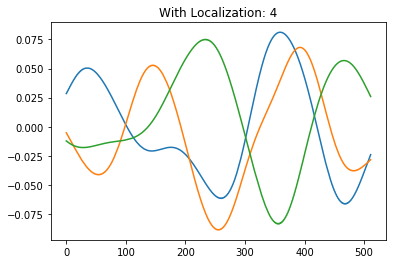

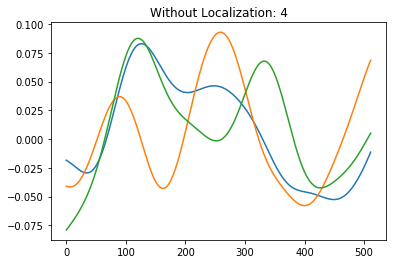

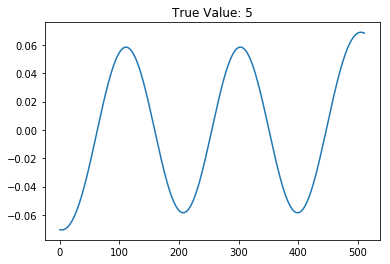

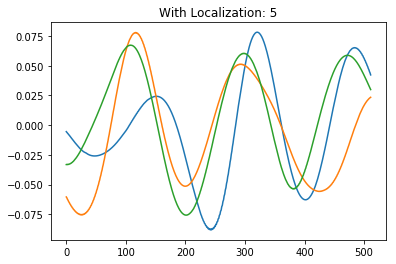

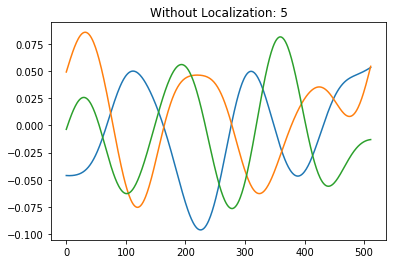

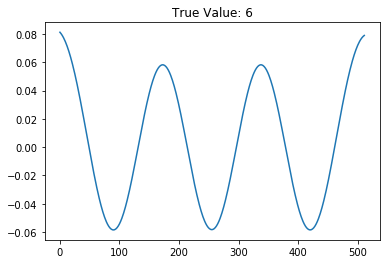

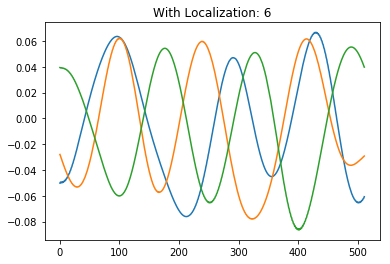

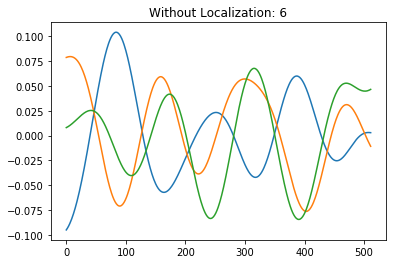

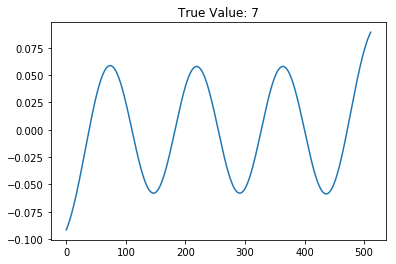

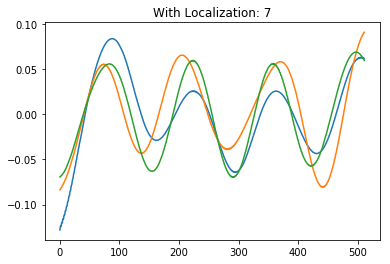

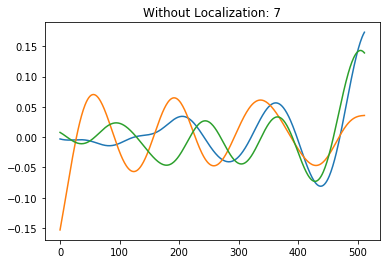

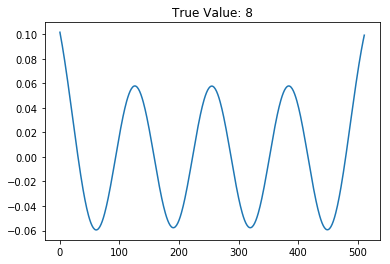

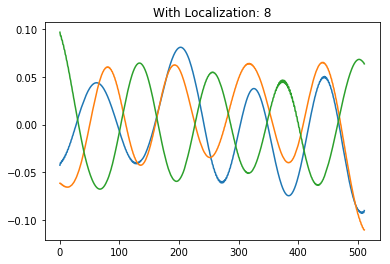

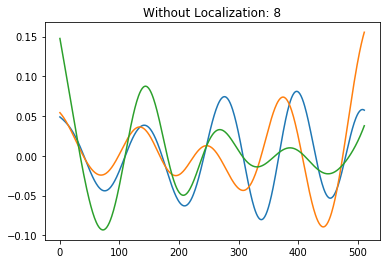

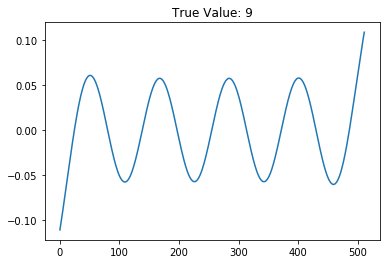

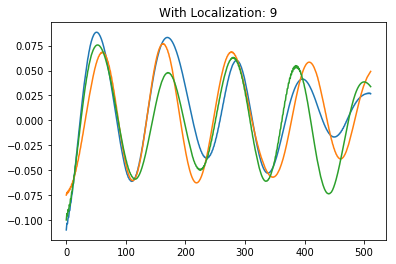

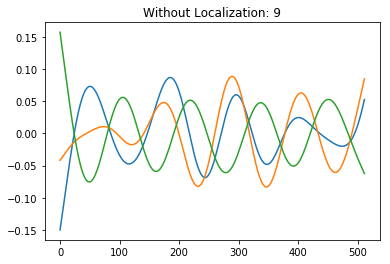

In [25]:
for this_sig in np.arange(10):
    plt.figure()
    plt.plot(VT[this_sig])
    plt.title(f'True Value: {this_sig}')
    
    plt.figure()
    plt.plot(opt_V_array[:, this_sig])
    plt.title(f'With Localization: {this_sig}')
    
    plt.figure()
    plt.plot(sample_V_array[:, this_sig])
    plt.title(f'Without Localization: {this_sig}')

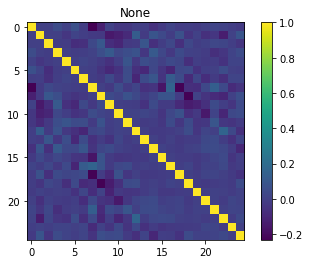

In [26]:
imshow(opt_V_array[:, :, 0].T @ opt_V_array[:, :, 0])